In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pickle
import os
from scipy.ndimage import gaussian_filter

plt.rcdefaults()

In [8]:
DATA_PATH = "MHD_data/dataset_pickle"
FILE_EXT = "pickle"


def load_shot(shotno, data_path, file_ext):
    file_path = os.path.join(data_path, f"{shotno}.{file_ext}")
    return pd.read_pickle(file_path)

def walk(struct, prefix="", append="  "):
    # simple function to inspect dict without printing all contents
    for key, item in struct.items():
        if not isinstance(item, dict):
            postfix = "" if not isinstance(item, np.ndarray) else f"{item.shape}"
            print(f"{prefix}{key}: var <{type(item).__name__}> {postfix}")
        else:
            print(f"{prefix}{key}\n{prefix}" + "{")
            walk(item, prefix=prefix+append, append=append)
            print(f"{prefix}" + "}")

In [9]:
# get all shot nos
all_shots = [int(os.path.basename(x.split(f".{FILE_EXT}")[0]))
             for x in glob.glob(os.path.join(DATA_PATH, f"*.{FILE_EXT}"))]
if len(all_shots) < 94:  # check if all data is there
    raise ValueError(f"Not all shots found in path /{DATA_PATH}/; found only {len(all_shots)} out of 94")

In [10]:
shotno = all_shots[38]
print(f"Example structure of shot #{shotno}:")
data_shot = load_shot(shotno, DATA_PATH, FILE_EXT)
walk(data_shot)

Example structure of shot #70382:
x
{
  spectrogram
  {
    OddN: var <ndarray> (3573, 2049)
    EvenN: var <ndarray> (3573, 2049)
    time: var <ndarray> (3573,)
    frequency: var <ndarray> (2049,)
  }
}
y
{
  modes
  {
    time: var <ndarray> (9156,)
    N0: var <ndarray> (9156,)
    N1: var <ndarray> (9156,)
    N2: var <ndarray> (9156,)
    N3: var <ndarray> (9156,)
    N4: var <ndarray> (9156,)
    LM: var <ndarray> (9156,)
  }
}


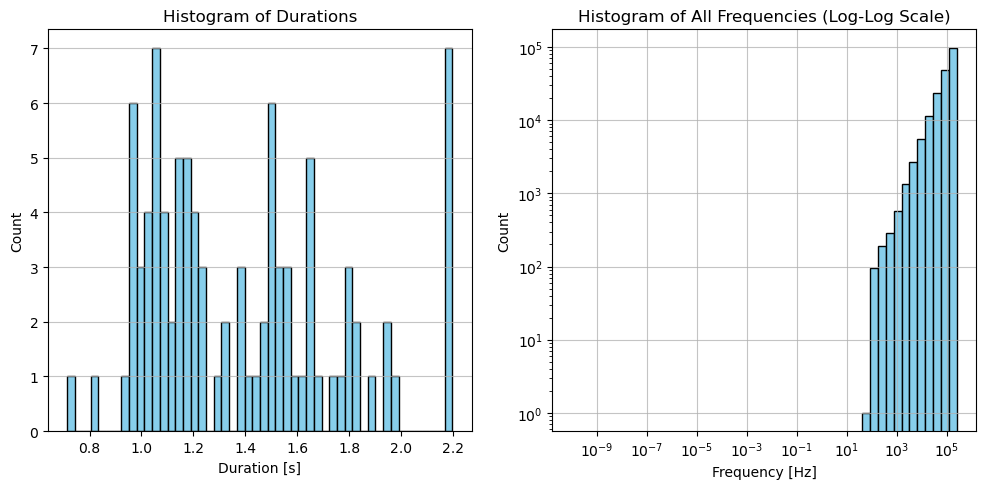

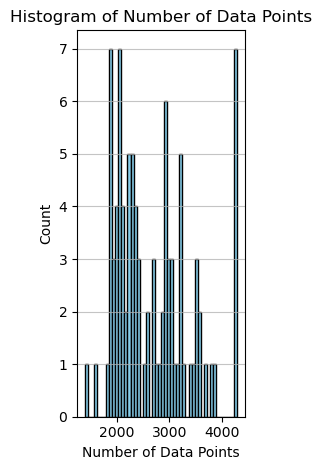

In [24]:
# Create empty lists to store the information
durations = []
all_frequencies = []
num_data_points = []

# Loop over all shots
for shotno in all_shots:
    # Load the data
    data_shot = load_shot(shotno, DATA_PATH, FILE_EXT)
    # Extract the frequency and time arrays
    f = data_shot["x"]["spectrogram"]["frequency"]
    t = data_shot["x"]["spectrogram"]["time"]
    # Append the duration to the list
    durations.append(t.max() - t.min())
    # Append all frequencies to the list
    all_frequencies.extend(f)
    # Append the number of data points to the list
    num_data_points.append(len(t))

# Plot the histogram of the durations
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(durations, bins=50, color='skyblue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Duration [s]")
plt.ylabel("Count")
plt.title("Histogram of Durations")

eps = 1e-10
# Plot the histogram of all frequencies with a log-log scale
plt.subplot(1, 3, 2)
plt.hist(all_frequencies, bins=np.logspace(np.log10(min(all_frequencies) + eps), np.log10(max(all_frequencies) + eps), 50), color='skyblue', edgecolor='black')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.grid(axis='both', alpha=0.75)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Count")
plt.title("Histogram of All Frequencies (Log-Log Scale)")
plt.tight_layout()
plt.show()
plt.clf()

# Plot the histogram of the number of data points
plt.subplot(1, 3, 3)
plt.hist(num_data_points, bins=50, color='skyblue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Number of Data Points")
plt.ylabel("Count")
plt.title("Histogram of Number of Data Points")

plt.tight_layout()
plt.show()


In [25]:
# Function to plot spectrogram
def plot_spectrogram(spec, title, time, frequency, start_longest_mode=None, end_longest_mode=None):
    fig, ax = plt.subplots()
    ax.imshow(spec.T, extent=(time[0], time[-1], frequency[0], frequency[-1]), aspect='auto', cmap='jet',
              origin='lower')
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(frequency[0], frequency[-1])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    fig.set_dpi(150)
    plt.title(title)

    # Plot vertical lines if start and end times are provided
    if start_longest_mode is not None and end_longest_mode is not None:
        ax.axvline(x=start_longest_mode, color='blue', linestyle='--', label='Start of Longest Mode')
        ax.axvline(x=end_longest_mode, color='darkblue', linestyle='--', label='End of Longest Mode')
        plt.legend(loc='upper left')

    plt.show()

In [26]:
# Extracting inputs
inputs = data_shot["x"]["spectrogram"]
spec_even = inputs["EvenN"]
spec_odd = inputs["OddN"]
f = inputs["frequency"]
t = inputs["time"]